In [1]:
import dLux as dl
import jax.numpy as np
import dLuxToliman as dlT
import dLux.utils as dlu
import matplotlib.pyplot as plt

In [83]:
# constructing the telescope:
wf_npixels = 300 # nice and low res
diameter = 0.125
period = 304e-6
difference = np.pi * 0.348

# get the transmission of the toliman aperture
apertureLayerTrans = dlT.TolimanApertureLayer(wf_npixels).transmission


# plt.imshow(apertureLayerTrans, origin='lower')
# plt.colorbar()
# plt.show()

# try generating a new aperture layer with normalise set to true?

apertureLayer = dl.TransmissiveLayer(apertureLayerTrans, True)

# plt.imshow(apertureLayer.transmission, origin='lower')
# plt.colorbar()
# plt.show()

# looks like normalise happens during propagation.
# calculate total flux on aperture layer:
total_power = np.sum(apertureLayerTrans**2)
print(total_power)


# normApertureLayerTrans = apertureLayerTrans/np.sqrt(total_power)
normApertureLayerTrans = apertureLayerTrans*wf_npixels**2/np.sqrt(total_power) #np.sqrt(91933)

# plt.imshow(normApertureLayerTrans,origin='lower')
# plt.colorbar()
# plt.show()

# should already be normalised, so going to set norm to false and see what happens when propagating.
newApertureLayer = dl.TransmissiveLayer(normApertureLayerTrans, False)

layers = [
    (
        'aperture',
        newApertureLayer
    )
]

layers2 = [
    (
        'aperture',
        apertureLayer
    )
]

psf_npixels = 128
pixel_scale = 1.92798496
oversample = 8 # high level oversample

optics = dl.AngularOpticalSystem(wf_npixels,diameter,layers,psf_npixels,pixel_scale,oversample)
optics2 = dl.AngularOpticalSystem(wf_npixels,diameter,layers2,psf_npixels,pixel_scale,oversample)

64136.727


1.1111085e-05
65536
0.52769333
258.1536
303.20456
1.4264872


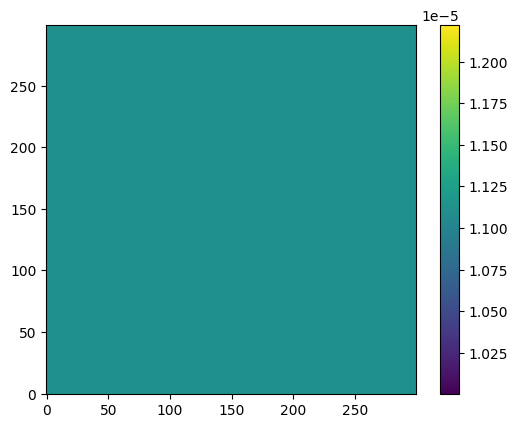

0.9999919
1.1111085e-05
0.9999976
0.9999919


In [93]:
# testing... testing... Note that this code cell came after all the others, so the ones below will make sense out of order.
new_wf = (1/wf_npixels**2)*np.ones([wf_npixels,wf_npixels])
newerNormApertureLayerTrans = 256**2*1/np.sqrt(np.sum(apertureLayerTrans))*apertureLayerTrans
print(np.sum(new_wf**2))
print(256**2)
print(np.sum((new_wf*newerNormApertureLayerTrans)**2))

print(256**2*1/np.sqrt(np.sum(apertureLayerTrans)))
print(np.sqrt(91933))
print(91933/np.sum(apertureLayerTrans))
plt.imshow(new_wf,origin='lower')
plt.colorbar()
plt.show()
# Oh my goodness. It appears Mr Desdoigts has made terrible mistake in his wavefront initialisation code..
# He appears to have made the same mistake that I made when trying to create it rofl
# let us test with the following:
lux_wavefront = dl.Wavefront(wf_npixels,diameter,585e-9)
print(np.sum((lux_wavefront.amplitude*wf_npixels)**2))
print(np.sum((lux_wavefront.amplitude)**2))
print(np.sum(lux_wavefront.psf)*wf_npixels**2)
# AHAHAHA YES I FOUND A (POTENTIAL) BUG IN DLUX I'M NOT GOING CRAZY AHAHAHAHAHAA
# In what I would presume to be a fundamental part of the code too... what the heck.
# HOLD your horses. Perhaps he simply wanted it normalised in amplitude?
print(np.sum(lux_wavefront.amplitude))
# yes... that may be the case. But why? It certainly breaks the fourier transform/parseval thing, which preserves intensity
# As in, taking the FT of a wavefront with power = 1 gives FT power = 1. But with total amplitude = 1? 
# Who's to say? amplitude isn't a magnitude, it also has sign so power could go all over the place.
# (Unless of course he represents the sign of amplitude with pi phase shifts in the wavefront, but seems unecessary)

In [85]:
source = dl.PointSource(wavelengths=np.array([585e-9]), flux=1)

psf = optics.model(source)
psf2 = optics2.model(source)

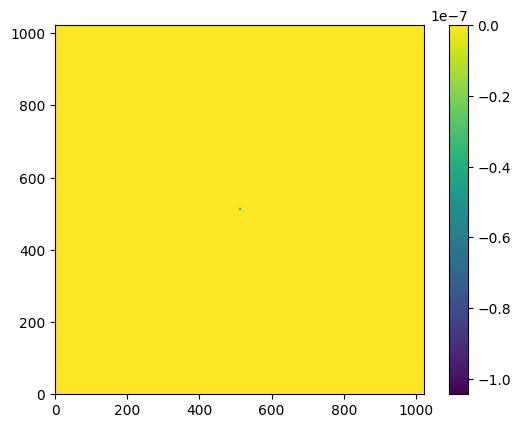

0.9997264
0.9997282
-1.7881393e-06


In [86]:
plt.imshow(psf-psf2, origin='lower')
plt.colorbar()
plt.show()

print(np.sum(psf))
print(np.sum(psf2))
print(np.sum(psf)-np.sum(psf2))

In [6]:
print(np.sqrt(91933))
# for some reason that right there is a great normalisng factor
# like basically zero difference between that and using norm=True.
# so now, let us finally calculate what we setout to calculate.

303.20456


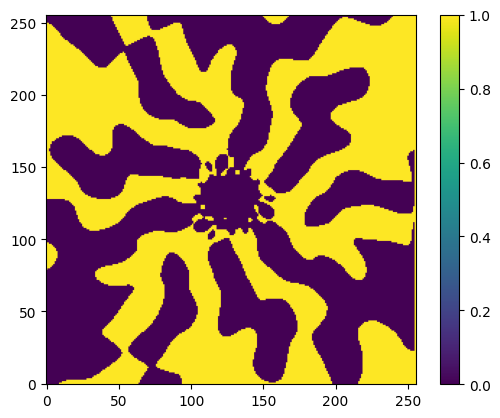

In [7]:
S2_norm = dlT.TolimanPupilLayer(wf_npixels).phase/np.pi
S1_norm = 1 - S2_norm

plt.imshow(S1_norm,origin='lower')
plt.colorbar()
plt.show()

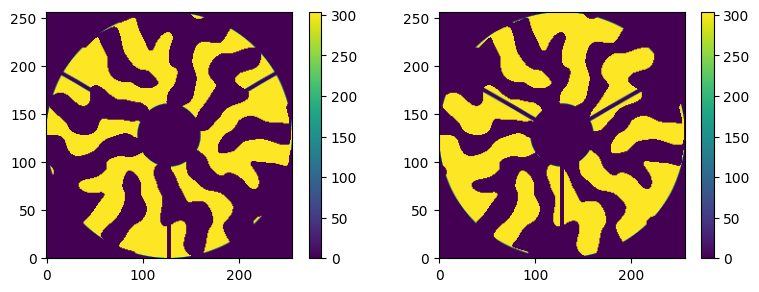

In [8]:
S1_total = normApertureLayerTrans*S1_norm
S2_total = normApertureLayerTrans*S2_norm
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.imshow(S1_total,origin='lower')
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(S2_total,origin='lower')
plt.colorbar()

plt.tight_layout()
plt.show()

In [9]:
S1_transmission = dl.TransmissiveLayer(S1_total)
S2_transmission = dl.TransmissiveLayer(S2_total)

S1_layers = [
    (
        'transmission',
        S1_transmission
    )
]

S2_layers = [
    (
        'transmission',
        S2_transmission
    )
]

S1_optics = dl.AngularOpticalSystem(wf_npixels,diameter,S1_layers,psf_npixels,pixel_scale,oversample)
S2_optics = dl.AngularOpticalSystem(wf_npixels,diameter,S2_layers,psf_npixels,pixel_scale,oversample)

S1_wf = S1_optics.model(source,True)
S2_wf = S2_optics.model(source,True)

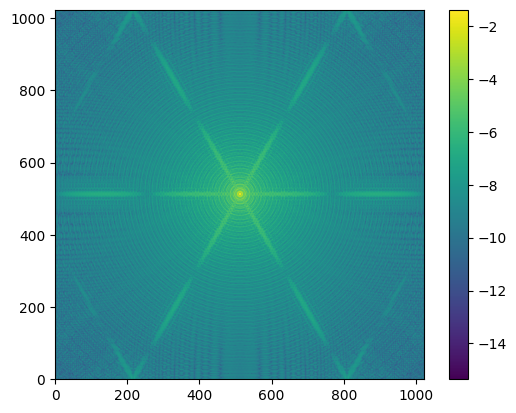

0.9999979


In [10]:
total_wf = (S1_wf.phasor + S2_wf.phasor)[0]

plt.imshow(np.log10(np.abs(total_wf)**2),origin='lower')
plt.colorbar()
plt.show()

print(np.sum(np.abs(total_wf)**2))
# AND as expected the fourier transform is linear THANK GOD THIS WORKED otherwise I'd be a bit angry.


In [11]:
# now let's do the actual maths
S1_field = S1_wf.phasor[0]
S2_field = S2_wf.phasor[0]

final_value = (np.sum(S1_field * np.conj(S2_field)) + np.sum(np.conj(S1_field)*S2_field))
final_image = S1_field * np.conj(S2_field) + np.conj(S1_field) * S2_field
print(final_value/np.sum(psf2))

(4.2522406e-05+0j)


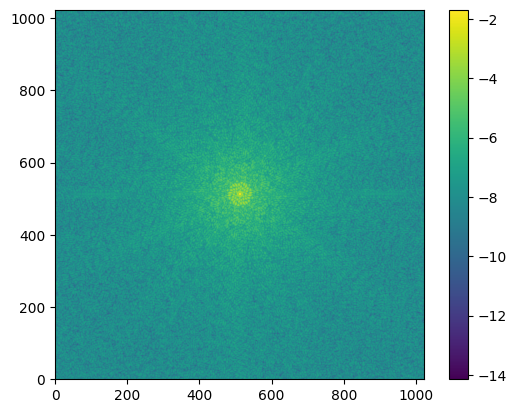

In [12]:
plt.imshow(np.log10(np.abs(final_image)),origin='lower')
plt.colorbar()
plt.show()

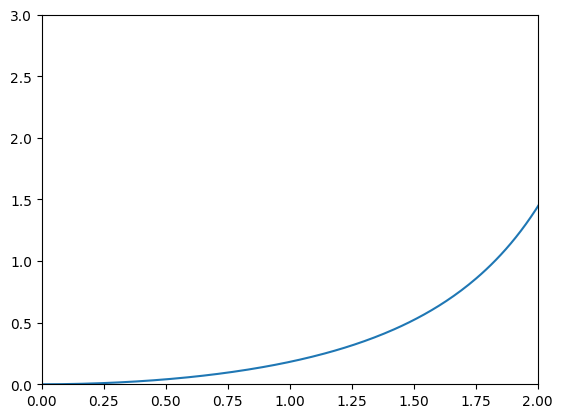

In [15]:
from scipy.special import jv
pds = np.linspace(0,10*np.pi,1000)


plt.plot(pds/np.pi, jv(1, pds/4)**2/jv(0, pds/4)**2)
plt.xlim(0,2)
plt.ylim(0,3)
plt.show()

# man it really seems like this line of reasoning/inquiry is dead.
# honestly feel like the only way forward is to get the central peak and scale according to that.
# AHHHH WAIT YOU FORGOT TO CALIBRATE WRT. DIFFRACTED APERTURE>>>>

# WAIT. IGNORE ABOVE COMMENTS. THIS PLOT TOTALLY WORKS. THE MATHS WORKS. I'M NOT CRAZY.
# THIS IS THE DEFINITIVE RELATIONSHIP BETWEEN SIDELOBE AND CENTRAL FLUX !!!